# Anomaly Detection Exercise using Tensorflow

In this notebook we will implement anomaly detection and apply it to detect failing servers on a network.
We first compute Multivariate Gaussian distribution on training set and validation set.
With the Validation set labels and Validation probability distribution we determine best Epsilon (threshold) and F1 score. Once we calculate these values these are applied to training set to determine the Outliers (anomalies).

**Dataset**
<br>
There are two sets of datasets examined.
Dataset1 is a simpler dataset with only two features which is helpful for data visualization.
Dataset2 is a more realistic dataset with more features. In this case we only determine the outliers as we cannot plot higher dimensions.

In [919]:
# import required modules

import tensorflow as tf
import numpy as np
from sklearn import metrics, model_selection
import matplotlib.pyplot as plt
import scipy.io  # for reading .mat files

%matplotlib inline

In [920]:
mat = scipy.io.loadmat('dataset1.mat')
print(mat.keys())

dict_keys(['yval', 'Xval', '__header__', 'X', '__version__', '__globals__'])


In [921]:
# Extract features and validation data
Features = mat['X']

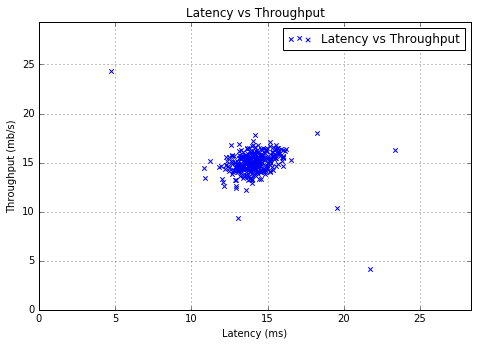

In [922]:
latency, throughput = Features[:, 0], Features[:, 1]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_xlim([0, np.max(latency)+5])
ax.set_ylim([0, np.max(throughput)+5])

ax.scatter(latency, throughput, color='blue', marker='x', label='Latency vs Throughput');
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')
ax.set_title('Latency vs Throughput')
ax.legend(loc='upper right')
ax.grid(axis='both')

In [923]:
X = Features
Xval = mat['Xval']
yval = mat['yval']

print("No. of features: %d" % X.shape[1])
print("No. of Examples in Training set: %d" % X.shape[0])
print("No. of Examples in Cross Validation set: %d" % Xval.shape[0])

mu = np.mean(X, axis=0)
sigma2 = np.var(X, axis=0)

No. of features: 2
No. of Examples in Training set: 307
No. of Examples in Cross Validation set: 307


In [924]:
# Multivariate Gaussian distribution using Tensorflow
def tf_multivariateGaussian(X, mu, sigma2):
    if sigma2.ndim == 1:
        Sigma2 = np.diag(sigma2)

    # setup placeholders
    Xt = tf.placeholder(dtype=tf.float32, shape=X.shape)
    Mu = tf.placeholder(dtype=tf.float32, shape=mu.shape)
    Sig = tf.placeholder(dtype=tf.float32, shape=Sigma2.shape)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as session:
        session.run(init);

        # calculate numerator and denominator separately
        nr = tf.exp(-(1 / 2) * tf.reduce_sum(tf.multiply(tf.matmul((Xt - Mu), tf.matrix_inverse(Sig)), (Xt - Mu)), axis=1));
        dr = tf.pow((2 * np.pi), (np.size(mu)/2)) * tf.sqrt(tf.matrix_determinant(Sig))
              
        nr_result = session.run(nr, feed_dict={Xt: X, Mu: mu, Sig: Sigma2});
        dr_result = session.run(dr, feed_dict={Sig: Sigma2})
        
    pdf = nr_result / dr_result;
    
    return pdf;

In [925]:
# Get Probability distribution for training set
pdf = tf_multivariateGaussian(X, mu, sigma2)

In [926]:
# Finding Outliers
# We will use validation set to determine best epsilon and F1 score

pval = tf_multivariateGaussian(Xval, mu, sigma2)

In [927]:
# Selecting epsilon
def selectThreshold(yval, pval):
    bestEpsilon = 0;
    bestF1 = 0;
    
    yval = np.where(yval == 1, 1, 0)
 
    step = (np.max(pval) - np.min(pval)) / 1000;
    epsilon_range = np.arange(np.min(pval), np.max(pval), step)
    
    # loop through epsilon range and select best Epsilon (threshold)
    for epsilon in epsilon_range:
        anomaly = np.where(pval < epsilon, 1, 0);
        anomaly = np.reshape(anomaly, yval.shape)

        true_positive = np.sum(np.logical_and((yval == 1), (anomaly == 1)))
        false_positive = np.sum(np.logical_and((yval == 0), (anomaly == 1)))
        false_negative = np.sum(np.logical_and((yval == 1), (anomaly == 0)))

        precision = true_positive / (true_positive + false_positive);
        recall = true_positive / (true_positive + false_negative);

        F1 = 2 * precision * recall / (precision + recall);

        if F1 > bestF1:
            bestF1 = F1;
            bestEpsilon = epsilon;

    return bestEpsilon, bestF1;


In [928]:
epsilon, F1 = selectThreshold(yval, pval);

# Now that we have best Epsilon, apply it on Training set to determine Outliers
outliers = X[pdf < epsilon]

print("Best Epsilon: %e, F1 Score: %.4f" % (epsilon, F1))
print("No. of Outliers: %d" % outliers.shape[0])

Best Epsilon: 8.990853e-05, F1 Score: 0.8750
No. of Outliers: 6


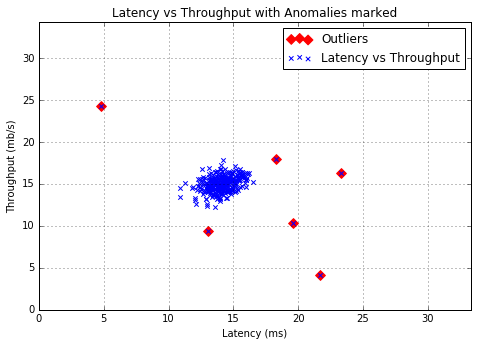

In [929]:
# Plot training data and mark selected outliers (anomalies)
latency, throughput = X[:, 0], X[:, 1]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_xlim([0, np.max(latency)+10])
ax.set_ylim([0, np.max(throughput)+10])

ax.scatter(outliers[:, 0], outliers[:, 1], color='red', marker='D', s=48, label='Outliers');
ax.scatter(latency, throughput, color='blue', marker='x', label='Latency vs Throughput');
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')
ax.set_title('Latency vs Throughput with Anomalies marked')
ax.legend(loc='upper right')
ax.grid(axis='both')

In [930]:
# Another dataset with more features
mat2 = scipy.io.loadmat('dataset2.mat')

X = mat2['X']
Xval = mat2['Xval']
yval = mat2['yval']

print("No. of features: %d" % X.shape[1])
print("No. of Examples in Training set: %d" % X.shape[0])
print("No. of Examples in Cross Validation set: %d" % Xval.shape[0])

mu = np.mean(X, axis=0)
sigma2 = np.var(X, axis=0)

# Get Probability distribution for training set
pdf = tf_multivariateGaussian(X, mu, sigma2)

# Get probability distribution for validation set and use it to determine best Epsilon (threshold)
pval = tf_multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval);
print("Best Epsilon: %e, F1 Score: %.4f" % (epsilon, F1))

# Now that we have best Epsilon, apply it on Training set to determine Outliers
outliers = X[pdf < epsilon]
print("No. of Outliers: %d" % outliers.shape[0])

No. of features: 11
No. of Examples in Training set: 1000
No. of Examples in Cross Validation set: 100
Best Epsilon: 1.377229e-18, F1 Score: 0.6154
No. of Outliers: 117


In [931]:
# Multivariate Gaussian distribution with standard Python
def multivariateGaussian(X, mu, sigma2):
    if sigma2.ndim == 1:
        Sigma2 = np.diag(sigma2)
        
    det_cov = np.linalg.det(Sigma2)
    
    nr = np.exp(-(1 / 2) * np.sum(np.matmul((X - mu), np.linalg.inv(Sigma2)) * (X - mu), axis=1))
    dr = ((2 * np.pi)**(np.size(mu)/2) * (det_cov**0.5))
    
    pdf = nr / dr;
    
    return pdf;